In [19]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import os

#define dataset for diffuser
class CovidDataset(Dataset):
    def __init__(self, root):
        self.path = [os.path.join(root, p) for p in os.listdir(root)]
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        img = Image.open(self.path[idx]).convert("RGB")
        return self.transform(img)

In [20]:
import torch
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dataset = CovidDataset(root="./covid_only_train")
loader = DataLoader(dataset, batch_size=16, shuffle=True)

#define diffusion model
model = UNet2DModel(
    sample_size=64,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )

).to(device)


Using device: cuda


In [21]:
#define scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

#100 epochs
EPOCHS = 100

In [22]:
#training loop

for epoch in range(EPOCHS):
    model.train()
    pbar = tqdm(loader)

    for batch in pbar:
        batch = batch.to(device)
        noise = torch.randn_like(batch)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.size(0),), device=device).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        pred = model(noisy, timesteps).sample
        loss = torch.nn.functional.mse_loss(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch} | Loss {loss.item():.4f}")
        

Epoch 0 | Loss 0.1036: 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]
Epoch 1 | Loss 0.3218: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 2 | Loss 0.0332: 100%|██████████| 17/17 [00:07<00:00,  2.42it/s]
Epoch 3 | Loss 0.0736: 100%|██████████| 17/17 [00:07<00:00,  2.42it/s]
Epoch 4 | Loss 0.0297: 100%|██████████| 17/17 [00:07<00:00,  2.42it/s]
Epoch 5 | Loss 0.0495: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 6 | Loss 0.0138: 100%|██████████| 17/17 [00:07<00:00,  2.42it/s]
Epoch 7 | Loss 0.0150: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 8 | Loss 0.0095: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 9 | Loss 0.0104: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 10 | Loss 0.0565: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 11 | Loss 0.0541: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 12 | Loss 0.0262: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 13 | Loss 0.1014: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Ep

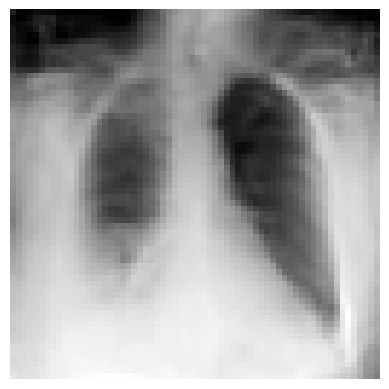

In [23]:
#visualize results
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    sample = torch.randn(1, 1, 64, 64).to(device)
    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            noise_pred = model(sample, t).sample
        sample = noise_scheduler.step(noise_pred, t, sample).prev_sample

    sample = (sample.clamp(-1, 1) + 1) / 2
    sample = sample.cpu().permute(0, 2, 3, 1).numpy()[0]

    plt.imshow(sample.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

In [24]:
#save model
torch.save(model.state_dict(), "covid_diffuser.pt")

In [25]:
#generate samples
from torchvision.utils import save_image

model.eval()
os.makedirs("covid_only_generated", exist_ok=True)

num_images = 500
for i in range(num_images):
    img = torch.randn((1, 1, 64, 64)).to(device)
    
    if i % 20 == 0:
        print(f"Generating image {i}/{num_images}")

    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            noise_pred = model(img, t).sample
        img = noise_scheduler.step(noise_pred, t, img).prev_sample
    
    save_image(
        (img + 1) / 2,
        f"covid_only_generated/generated_{i}.jpg"
    )

Generating image 0/500
Generating image 20/500
Generating image 40/500
Generating image 60/500
Generating image 80/500
Generating image 100/500
Generating image 120/500
Generating image 140/500
Generating image 160/500
Generating image 180/500
Generating image 200/500
Generating image 220/500
Generating image 240/500
Generating image 260/500
Generating image 280/500
Generating image 300/500
Generating image 320/500
Generating image 340/500
Generating image 360/500
Generating image 380/500
Generating image 400/500
Generating image 420/500
Generating image 440/500
Generating image 460/500
Generating image 480/500


In [26]:
#define diffusion model with attention
attn_model = UNet2DModel(
    sample_size=64,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D", #attention block
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    )

).to(device)

In [27]:
#define scheduler and optimizer
attn_noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
attn_optimizer = torch.optim.AdamW(attn_model.parameters(), lr=1e-4)


In [28]:
#training loop

for epoch in range(EPOCHS):
    attn_model.train()
    pbar = tqdm(loader)

    for batch in pbar:
        batch = batch.to(device)
        noise = torch.randn_like(batch)
        timesteps = torch.randint(0, attn_noise_scheduler.num_train_timesteps, (batch.size(0),), device=device).long()

        noisy = attn_noise_scheduler.add_noise(batch, noise, timesteps)
        pred = attn_model(noisy, timesteps).sample
        loss = torch.nn.functional.mse_loss(pred, noise)

        attn_optimizer.zero_grad()
        loss.backward()
        attn_optimizer.step()

        pbar.set_description(f"Epoch {epoch} | Loss {loss.item():.4f}")

Epoch 0 | Loss 0.0722: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]
Epoch 1 | Loss 0.0371: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 2 | Loss 0.0430: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 3 | Loss 0.0381: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 4 | Loss 0.0271: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 5 | Loss 0.0194: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 6 | Loss 0.0509: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 7 | Loss 0.0805: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 8 | Loss 0.0518: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 9 | Loss 0.0172: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 10 | Loss 0.0513: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 11 | Loss 0.0097: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]
Epoch 12 | Loss 0.0128: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Epoch 13 | Loss 0.0986: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s]
Ep

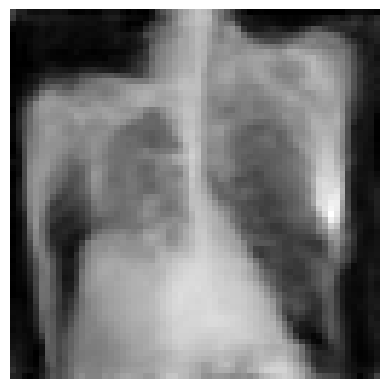

In [29]:
#visualize results
import matplotlib.pyplot as plt
attn_model.eval()
with torch.no_grad():
    sample = torch.randn(1, 1, 64, 64).to(device)
    for t in attn_noise_scheduler.timesteps:
        with torch.no_grad():
            noise_pred = attn_model(sample, t).sample
        sample = attn_noise_scheduler.step(noise_pred, t, sample).prev_sample

    sample = (sample.clamp(-1, 1) + 1) / 2
    sample = sample.cpu().permute(0, 2, 3, 1).numpy()[0]

    plt.imshow(sample.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

In [30]:
#generate samples

attn_model.eval()
os.makedirs("covid_only_attn_generated", exist_ok=True)

num_images = 500
for i in range(num_images):
    img = torch.randn((1, 1, 64, 64)).to(device)
    
    if i % 20 == 0:
        print(f"Generating image {i}/{num_images}")

    for t in attn_noise_scheduler.timesteps:
        with torch.no_grad():
            noise_pred = attn_model(img, t).sample
        img = attn_noise_scheduler.step(noise_pred, t, img).prev_sample
    
    save_image(
        (img + 1) / 2,
        f"covid_only_attn_generated/attn_generated_{i}.jpg"
    )

Generating image 0/500
Generating image 20/500
Generating image 40/500
Generating image 60/500
Generating image 80/500
Generating image 100/500
Generating image 120/500
Generating image 140/500
Generating image 160/500
Generating image 180/500
Generating image 200/500
Generating image 220/500
Generating image 240/500
Generating image 260/500
Generating image 280/500
Generating image 300/500
Generating image 320/500
Generating image 340/500
Generating image 360/500
Generating image 380/500
Generating image 400/500
Generating image 420/500
Generating image 440/500
Generating image 460/500
Generating image 480/500


In [31]:
#save model
torch.save(model.state_dict(), "covid_diffuser_attn.pt")